In [1]:
import yaml

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import probplot

import sys
sys.path.append("../")

from electronfactors.model.utilities import create_model, pull_data, fit_give, estimate_population_uncertainty
from electronfactors.visuals.utilities import create_green_cm

In [2]:
green_cm = create_green_cm()

def colour(x, alpha=1):
    result = list(green_cm(x))
    result[3] = alpha
    
    return result

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif',
             'size':'16'})
rc('text', usetex=True)

In [4]:
def create_histogram(data):
    plt.figure(figsize=(6 * 1.618, 6))
    
    bins = np.arange(-1.5, 2, 0.5)
    dbins = bins[1] - bins[0]
    binsTrans = bins - dbins/2

    binsTrans = binsTrans.reshape(-1,1)
    binNum = np.argmin(abs(binsTrans - data),0)

    representative_height = np.zeros(len(binNum))

    for i in range(len(bins)):
        binRef = (binNum == i)
        representative_height[binRef] = np.arange(sum(binRef)) + 1

    plt.hist(data, bins, alpha=0.6, lw=2)
    plt.scatter(data, representative_height, zorder=2, s=120, alpha=0.8, lw=1.5)
    
    uncertainty = estimate_population_uncertainty(data)
    
    print("Mean = %0.2f" % (np.mean(data)))
    print("Uncertainty = %0.2f" % (uncertainty))

In [5]:
def display_fit(width, eqPonA, factor, model):
    plt.figure(figsize=(6 * 1.618, 6))
    x = np.arange(np.floor(np.min(width)) - 0.5, np.ceil(np.max(width)) + 0.5, 0.05)
    y = np.arange(np.floor(np.min(eqPonA)*10)/10 - 0.2, np.ceil(np.max(eqPonA)*10)/10 + 0.2, 0.005)

    xx, yy = np.meshgrid(x, y)

    zz = model(xx, yy)
    give = fit_give(xx, yy, width, eqPonA, factor, kx=2, ky=1)

    outOfTolerance = (give > 0.5)

    zz[outOfTolerance] = np.nan

    c = plt.contourf(xx, yy, zz, 100, alpha=1)
    plt.colorbar(c)

    plt.contour(xx, yy, give, levels=[0.5], colors='g')

    plt.scatter(width, eqPonA, s=45, alpha=0.9, zorder=3)

    plt.xlabel(r'Width (cm)')
    plt.ylabel(r'Perimeter / Area (cm$^{-1}$)')
    plt.title(r'Bivariate spline fit')

In [6]:
# width, length, eqPonA, factor = pull_data(energy=12)

with open("model_cache/12MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)
    
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

custom_label = label[~book_factor]

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

perimeter = np.pi / 2 * (3*(width + length) - np.sqrt((3*width + length)*(3*length + width)))
area = np.pi / 4 * width * length
eqPonA = perimeter / area

In [27]:
amount = 15
order = np.arange(len(width))
np.random.shuffle(order)
reference = order[0:amount]
reference

array([24, 19,  1, 35, 34, 13, 37, 30, 33, 32,  2, 36, 23, 26, 20])

In [28]:
width[reference]

array([ 5.26,  6.54,  5.26,  7.08,  6.78,  3.71,  6.41,  5.72,  7.82,
        6.08,  4.21,  3.66,  4.2 ,  4.59,  4.59])

In [29]:
eqPonA[reference]

array([ 0.55292088,  0.54575098,  0.58629662,  0.47320223,  0.48382914,
        0.99841277,  0.54525668,  0.53721669,  0.4429889 ,  0.63045757,
        0.73274935,  0.94921616,  0.95125019,  0.79064916,  0.74724175])

In [30]:
factor[reference]

array([ 0.9868,  0.9931,  0.9879,  1.0052,  1.0067,  0.9489,  0.9991,
        0.9989,  1.0019,  0.9933,  0.9708,  0.9437,  0.9562,  0.9587,
        0.9683])

In [31]:
check = np.setdiff1d(np.arange(len(width)), reference)
check

array([ 0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 21,
       22, 25, 27, 28, 29, 31, 38, 39, 40, 41])

In [32]:
give = np.zeros(len(check))
predictions = np.zeros(len(check))

model = create_model(width[reference], eqPonA[reference], factor[reference])

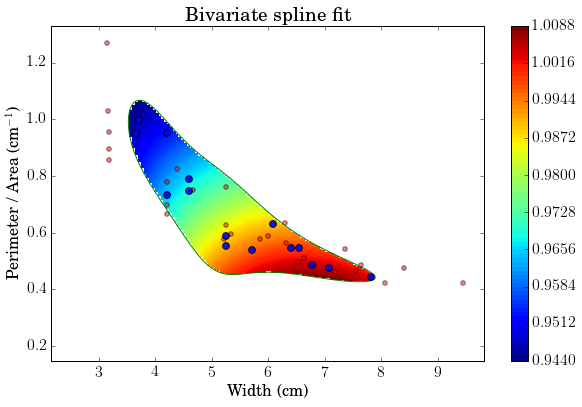

In [33]:
display_fit(width[reference], eqPonA[reference], factor[reference], model)
plt.scatter(width[check], eqPonA[check], c='red', alpha=0.5)

In [34]:
for i, value in enumerate(check):
    predictions[i] = model(width[value], eqPonA[value])
    give[i] = fit_give(
        width[value], eqPonA[value], 
        width[reference], eqPonA[reference], factor[reference])

percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]

valid = give < 0.5

Mean = -0.07
Uncertainty = 0.37


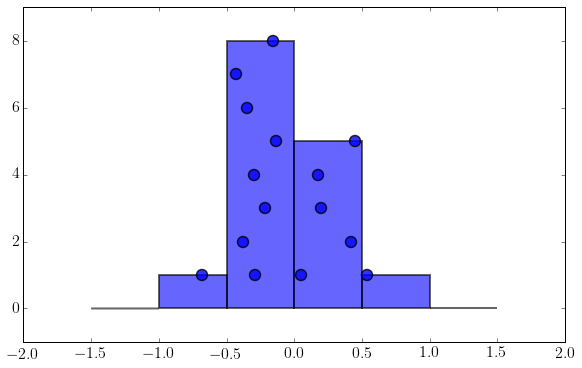

In [35]:
create_histogram(percent_prediction_differences[valid])

In [16]:
store = np.array([])
mean_diff = np.array([])
individual_std = np.array([])

In [17]:
amount = 15

for j in range(1000):
    order = np.arange(len(width))
    np.random.shuffle(order)
    reference = order[0:amount]
    reference
    check = np.setdiff1d(np.arange(len(width)), reference)
    check
    give = np.zeros(len(check))
    predictions = np.zeros(len(check))

    model = create_model(width[reference], eqPonA[reference], factor[reference])

    for i, value in enumerate(check):
        predictions[i] = model(width[value], eqPonA[value])
        give[i] = fit_give(
            width[value], eqPonA[value], 
            width[reference], eqPonA[reference], factor[reference])

    percent_prediction_differences = 100*(factor[check] - predictions) / factor[check]

    valid = give < 0.5
    store = np.append(store, percent_prediction_differences[valid])
    mean_diff = np.append(mean_diff, np.mean(percent_prediction_differences[valid]))
    individual_std = np.append(individual_std, np.std(percent_prediction_differences[valid]))

Mean = -0.02
Uncertainty = 0.43


..\electronfactors\model\utilities.py:144: RuntimeWarning: invalid value encountered in double_scalars
  output = np.sqrt(2/(n-1)) * gamma(n/2) / gamma((n-1)/2)


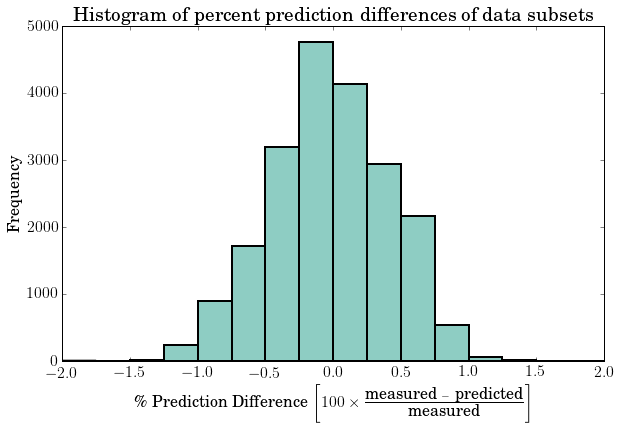

In [18]:
bins = np.arange(-2, 2.25, 0.25)

plt.figure(figsize=(6 * 1.618, 6))

plt.hist(store, bins, lw=2, fc=colour(0.55, alpha=0.5))

uncertainty = estimate_population_uncertainty(store)

print("Mean = %0.2f" % (np.mean(store)))
print("Uncertainty = %0.2f" % (uncertainty))

plt.xlabel(
    r'\% Prediction Difference '
    r'$\left[100 \times \frac{\mbox{measured } - \mbox{ predicted}}{\mbox{measured}} \right]$')
plt.ylabel(r'Frequency')
plt.title(r'Histogram of percent prediction differences of data subsets')

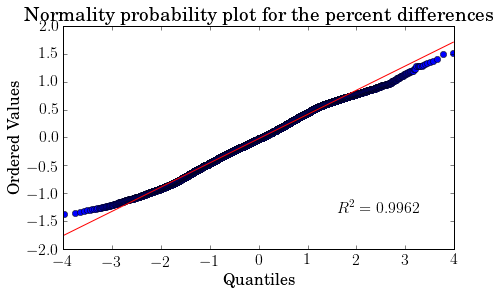

In [19]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

probplot(store, plot=ax);

ax.set_title("Normality probability plot for the percent differences")

In [20]:
np.min(store)

-1.3690220058025162

In [21]:
len(store)

20615

In [22]:
mean_diff = mean_diff[~np.isnan(mean_diff)]

np.mean(np.abs(mean_diff))

0.11461705199789236

(array([   6.,   31.,   80.,  153.,  211.,  249.,  160.,   77.,   22.,   11.]),
 array([-0.45523307, -0.3688766 , -0.28252013, -0.19616366, -0.10980719,
        -0.02345072,  0.06290575,  0.14926222,  0.23561869,  0.32197516,
         0.40833163]),
 <a list of 10 Patch objects>)

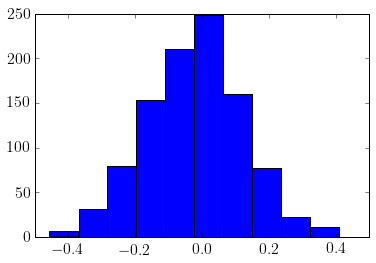

In [23]:
plt.hist(mean_diff)

In [36]:
np.std(mean_diff)

0.14347746911412515

In [24]:
individual_std = individual_std[~np.isnan(individual_std)]
np.mean(np.abs(individual_std))

0.40625385378809437

(array([  20.,   63.,  166.,  227.,  239.,  154.,   83.,   37.,    6.,    5.]),
 array([ 0.26476883,  0.29890449,  0.33304016,  0.36717583,  0.40131149,
         0.43544716,  0.46958283,  0.50371849,  0.53785416,  0.57198982,
         0.60612549]),
 <a list of 10 Patch objects>)

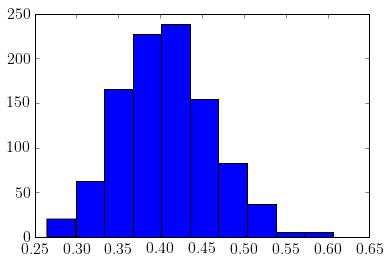

In [25]:
plt.hist(individual_std)

(array([  21.,  108.,  205.,  226.,  185.,  129.,   72.,   40.,   12.,    2.]),
 array([ 0.30277606,  0.35854547,  0.41431488,  0.47008429,  0.5258537 ,
         0.58162311,  0.63739252,  0.69316193,  0.74893134,  0.80470075,
         0.86047015]),
 <a list of 10 Patch objects>)

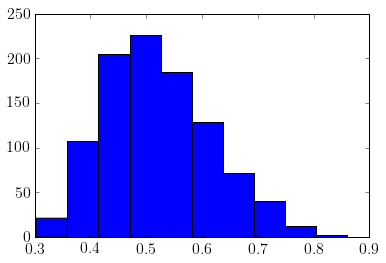

In [26]:
plt.hist(individual_std + np.abs(mean_diff))